In [203]:
import torch
import torchvision
from torch.nn import functional as F
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from einops import rearrange
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cluster import MiniBatchKMeans


In [204]:
path_to_dataset = "../complete_new_model/datasets"
batch_size = 64

transform_to_tensor = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(root=path_to_dataset, download=True, transform=transform_to_tensor, train=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


tensor(0.) tensor(1.)


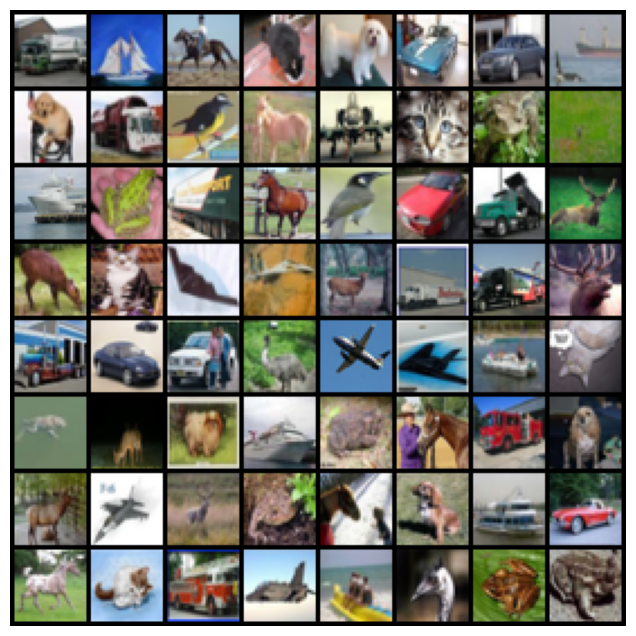

In [205]:

# Show an example batch
images, attributes = next(iter(train_dataloader))
print(images.min(), images.max())
grid = torchvision.utils.make_grid(images, normalize=True)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1, 2, 0))  # CHW to HWC
plt.axis('off')
plt.show() 

In [206]:
# Load palette
palette_path = "../color reduction palettes/cifar10_palette_8bit.npy"
palette = torch.tensor(np.load(palette_path))

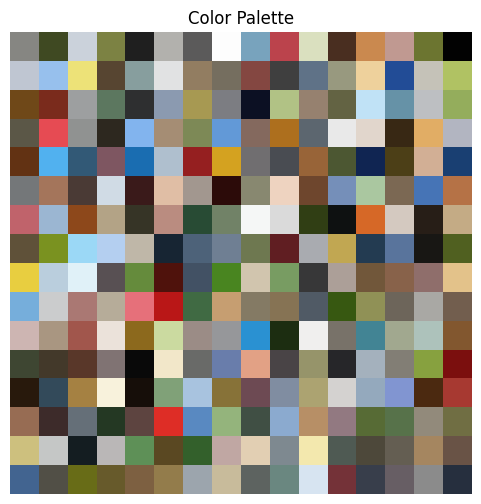

In [207]:
# Plot palette


palette.shape# Ensure values are in [0, 1] for matplotlib

copy_palette = palette.clone()

if copy_palette.max() > 1.0:
    copy_palette = copy_palette / 255.0

# Compute size for square grid
num_colors = copy_palette.shape[0]
grid_size = int(math.ceil(math.sqrt(num_colors)))  # e.g., 23x23 for 512

# Pad if not a perfect square
padding = grid_size ** 2 - num_colors
if padding > 0:
    pad = torch.ones(padding, 3)  # white padding or change to zeros for black
    copy_palette = torch.cat([copy_palette, pad], dim=0)

# Reshape to [H, W, 3] for image plotting
palette_image = copy_palette.view(grid_size, grid_size, 3)

# Plot
plt.figure(figsize=(6, 6))
plt.imshow(palette_image)
plt.axis('off')
plt.title("Color Palette")
plt.show()

In [208]:
def quantize_batch_to_palette_indices(images: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Quantizes each pixel in the input batch to the nearest palette color index.

    Args:
        images: Tensor of shape [B, 3, H, W], uint8, values in [0, 255]
        palette: Tensor of shape [K, 3], uint8, values in [0, 255]
        k: Number of colors in the palette

    Returns:
        Tensor of shape [B, H, W], with palette indices (0 to K-1) as int64
    """
    assert images.shape[1] == 3, "Images must be RGB"
    B, C, H, W = images.shape

    pixels = images.permute(0, 2, 3, 1).reshape(-1, 3).float()  # [B*H*W, 3]
    palette = palette.float()  # [K, 3]

    dists = torch.cdist(pixels, palette)  # [B*H*W, K]
    nearest_idx = torch.argmin(dists, dim=1)  # [B*H*W]

    indices = nearest_idx.reshape(B, H, W)  # [B, H, W]

    # TODO: We assume colors = 2**8 so we can convert to uint8
    assert indices.min() >= 0 and indices.max() < 2 ** 8, "Indices must be in range [0, K-1]"
    indices = indices.to(torch.uint8)
    return indices

def reconstruct_from_indices(indices: torch.Tensor, palette: torch.Tensor) -> torch.Tensor:
    """
    Converts quantized palette indices [B, H, W] back to RGB images using the palette [K, 3].

    Args:
        indices: Tensor of shape [B, H, W], dtype uint8 or long
        palette: Tensor of shape [K, 3], dtype uint8

    Returns:
        Tensor of shape [B, 3, H, W], dtype uint8
    """
    assert indices.dim() == 3, "Expected shape [B, H, W]"
    assert palette.dim() == 2 and palette.shape[1] == 3, "Expected palette shape [K, 3]"

    B, H, W = indices.shape
    flat_indices = indices.reshape(-1).long()  # ensure type is long
    palette = palette.to(indices.device)       # move to same device

    # Lookup RGB colors
    rgb = palette[flat_indices]  # [B*H*W, 3]

    # Reshape back to [B, 3, H, W]
    rgb = rgb.reshape(B, H, W, 3).permute(0, 3, 1, 2).contiguous()
    return rgb



torch.Size([8, 32, 32]) torch.uint8


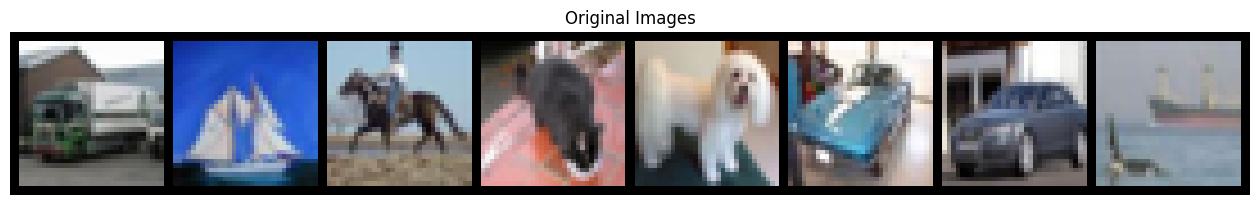

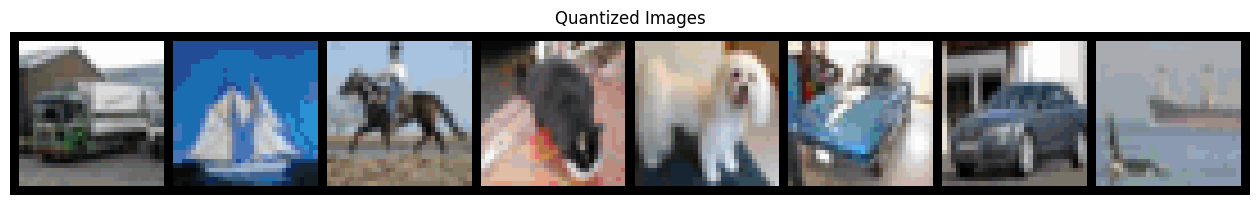

In [209]:
# quantize a batch of images to the palette

s, e = 0, 8

images = images[s:e]

# scale to 0–255
images = (images * 255).to(torch.uint8)

# Quantize the images using your palette
quants = quantize_batch_to_palette_indices(images, palette)
print(quants.shape, quants.dtype)

rgb_reconstructed = reconstruct_from_indices(quants, palette)
grid = torchvision.utils.make_grid(rgb_reconstructed)

# Rearrange for plotting
grid = rearrange(grid, "c h w -> h w c")

# Plot
grid2 = torchvision.utils.make_grid(images[s:e])
grid2 = rearrange(grid2, "c h w -> h w c")
plt.figure(figsize=(16, 8))
plt.imshow(grid2)
plt.axis("off")
plt.title("Original Images")
plt.show()


plt.figure(figsize=(16, 8))
plt.imshow(grid)
plt.axis("off")
plt.title("Quantized Images")
plt.show()


In [218]:
images, _ = next(iter(train_dataloader))
images = images[:8]

print("Original images:\t", images.shape, "\t", images.dtype)
print("Quants:\t\t\t", quants.shape, "\t", quants.dtype)

def tensor_size_bytes(tensor: torch.Tensor) -> int:
    return tensor.nelement() * tensor.element_size()

print(f"Original batch size: {tensor_size_bytes(images):,} bytes")
print(f"Quantized batch size: {tensor_size_bytes(quants):,} bytes")

print("We achieved reduction of",
      f"{(tensor_size_bytes(images) - tensor_size_bytes(quants)) / tensor_size_bytes(images) * 100:.2f}% in size.")

Original images:	 torch.Size([8, 3, 32, 32]) 	 torch.float32
Quants:			 torch.Size([8, 32, 32]) 	 torch.uint8
Original batch size: 98,304 bytes
Quantized batch size: 8,192 bytes
We achieved reduction of 91.67% in size.


# Uint8 is only [0, 255]

In [221]:
torch.tensor([256], dtype=torch.uint8)

RuntimeError: value cannot be converted to type uint8 without overflow